# Notification

In [127]:
from twilio.rest import Client
import os

account_sid = os.getenv('TWILIO_ACCOUNT_SID')
auth_token = os.getenv('TWILIO_AUTH_TOKEN')
twilio_number = os.getenv('TWILIO_SMS_FROM')
to=os.getenv('TWILIO_SMS_TO')
message_body = 'See? It\'s working!. OMG You\'re garage door is open!!'
client = Client(account_sid, auth_token)
client.messages.create(to=to,
                       from_=twilio_number,
                       body=message_body,
                       status_callback='')

<Twilio.Api.V2010.MessageInstance sid=SM8c2d692c9a264d4ab42eba77fbb75828 account_sid=AC9e4b375cbcd0ba68b0b0233f74445c57>

# Simple Detection

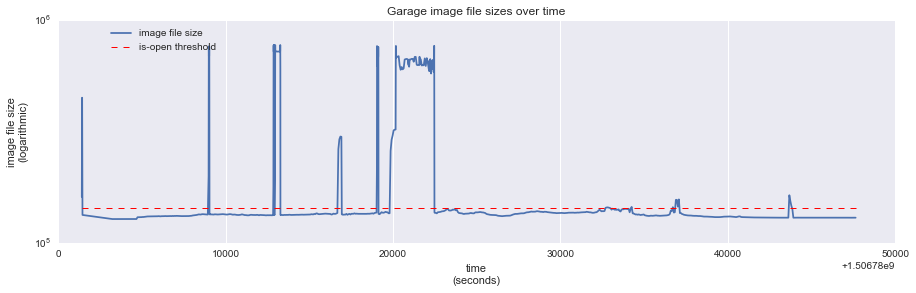

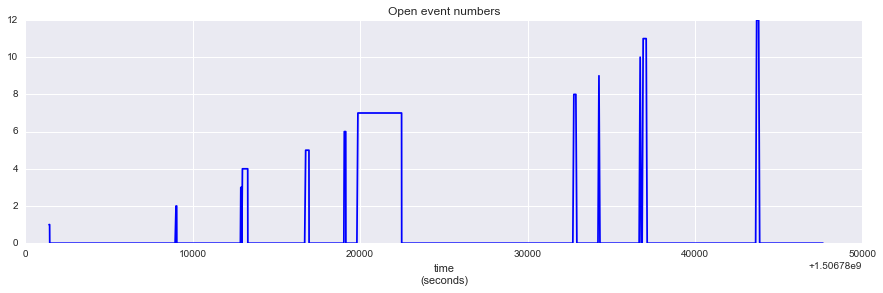

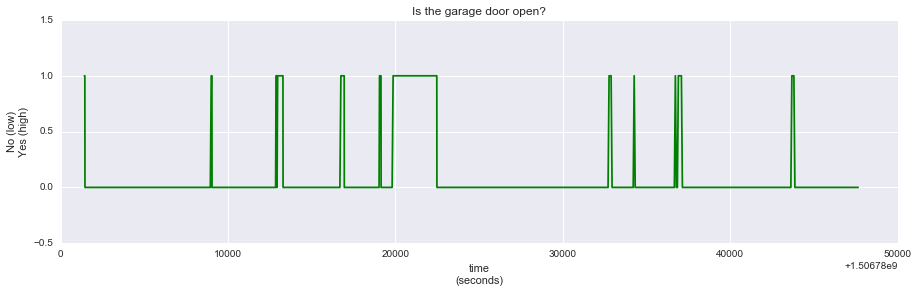

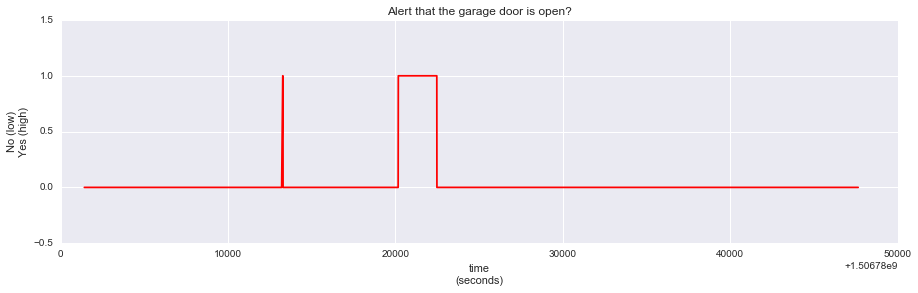

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import time

filenames = glob('images/*.jpg')
file_sizes = [os.path.getsize(filename) for filename in filenames]
file_times = [os.stat(filename).st_mtime for filename in filenames]

min_file_size = np.min(file_sizes)
max_file_size = np.max(file_sizes)
threshold_fraction = 0.025
threshold_size = threshold_fraction*(max_file_size - min_file_size) + min_file_size

is_open = [1 if size > threshold_size else 0 for size in file_sizes]

open_since = None
is_open_alert = []
event_numbers = []
event_number = 0
for time_step, is_open_now in zip(file_times, is_open):
    if is_open_now and open_since is None:
        open_since = time_step
        event_number += 1
    elif not is_open_now:
        open_since = None
        
    if is_open_now:
        event_numbers.append(event_number)
    else:
        event_numbers.append(0)
        
    if open_since is None:
        is_open_alert.append(0)
    elif time_step - open_since > 5*60:
        is_open_alert.append(1)
    else:
        is_open_alert.append(0)

plt.figure(figsize=(15,4))
plt.plot(file_times, file_sizes, label='image file size')
plt.title('Garage image file sizes over time')
plt.xlabel('time\n(seconds)')
plt.yscale('log')
plt.ylabel('image file size\n(logarithmic)')
plt.plot([np.min(file_times), np.max(file_times)], [threshold_size, threshold_size], color='r', linestyle='--', linewidth=1, label='is-open threshold')
plt.legend(bbox_to_anchor=(0.2, 1))
plt.show()

plt.figure(figsize=(15,4))
plt.plot(file_times, event_numbers, color='b')
plt.title('Open event numbers')
plt.xlabel('time\n(seconds)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(file_times, is_open, color='g')
plt.ylim(-0.5, 1.5)
plt.title('Is the garage door open?')
plt.xlabel('time\n(seconds)')
plt.ylabel('No (low)\nYes (high)')
plt.show()
        
plt.figure(figsize=(15,4))
plt.plot(file_times, is_open_alert, color='r')
plt.ylim(-0.5, 1.5)
plt.title('Alert that the garage door is open?')
plt.xlabel('time\n(seconds)')
plt.ylabel('No (low)\nYes (high)')
plt.show()


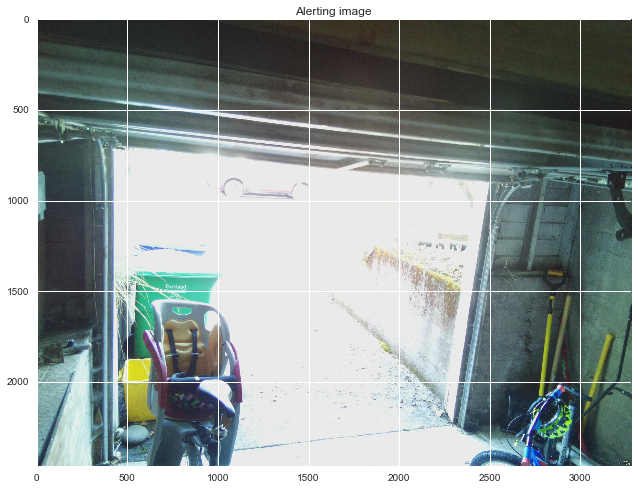

In [2]:
first_alert_filename, _ = filter(lambda (_, is_alert): is_alert, zip(filenames, is_open_alert))[0]
image = Image.open(first_alert_filename)
plt.figure(figsize=(15,8))
plt.title('Alerting image')
plt.imshow(np.asarray(image))

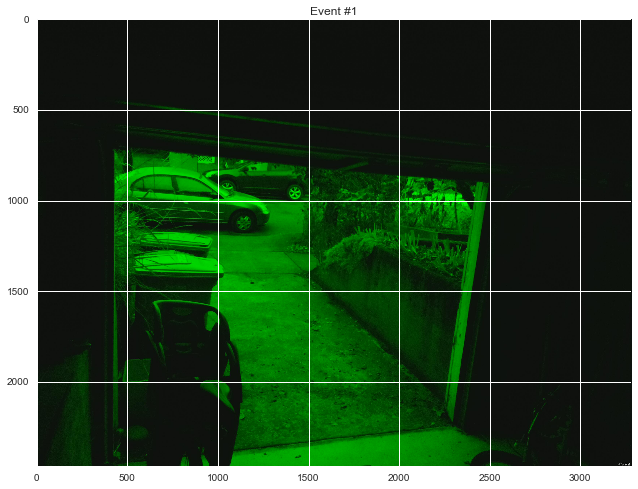

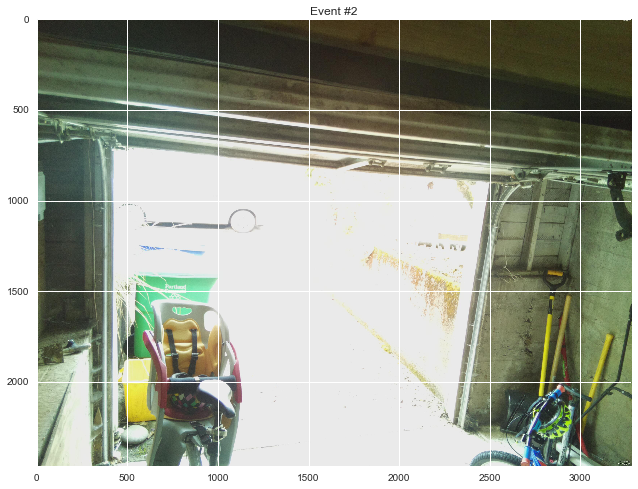

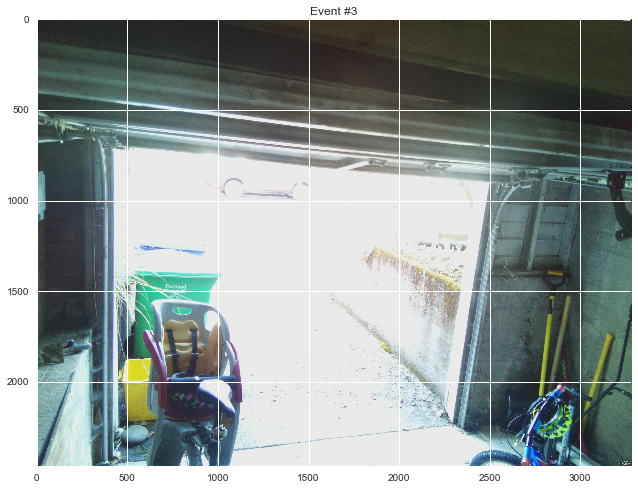

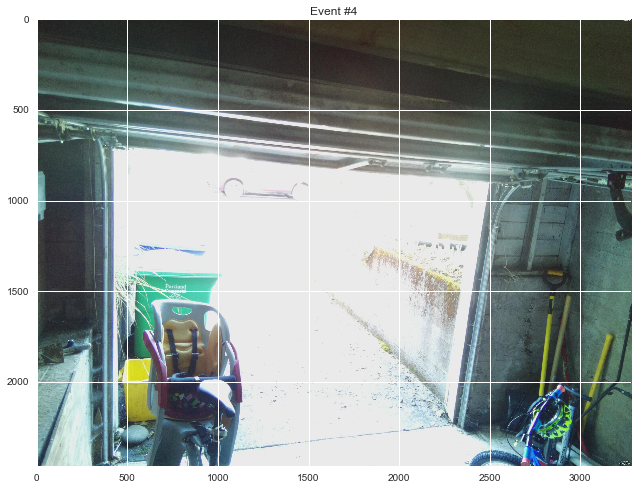

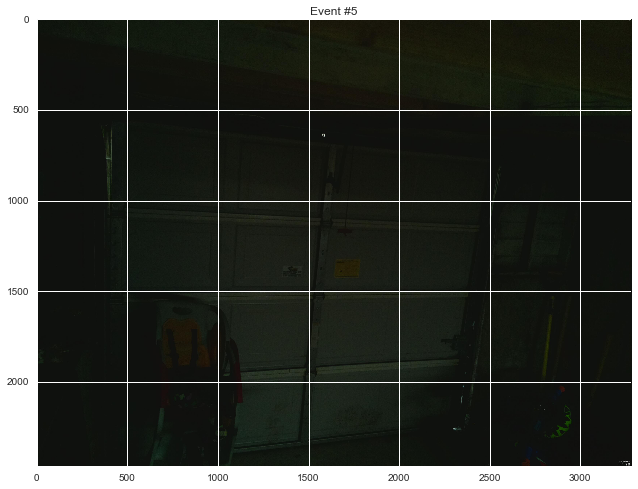

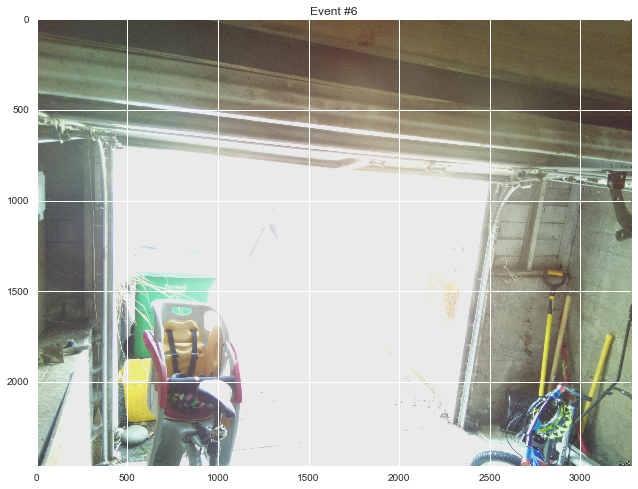

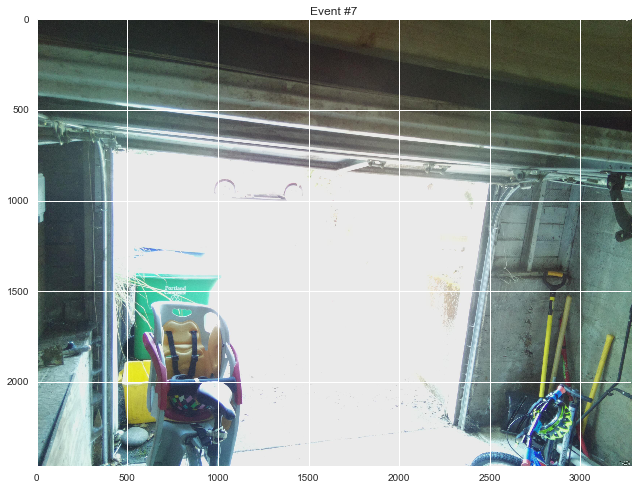

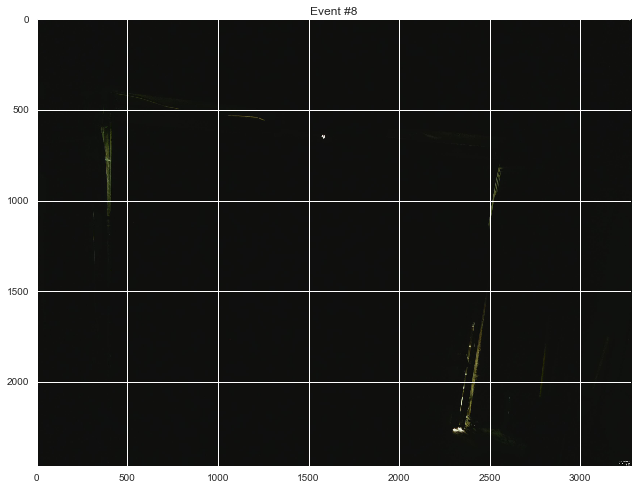

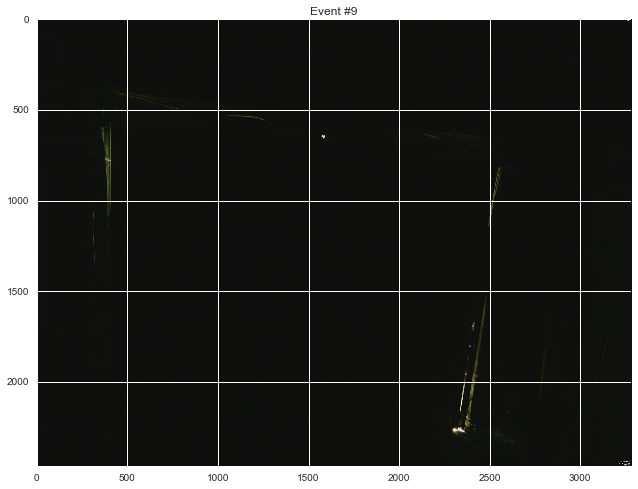

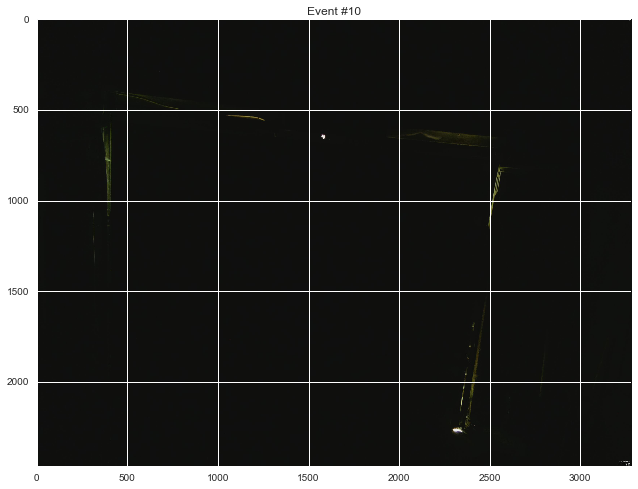

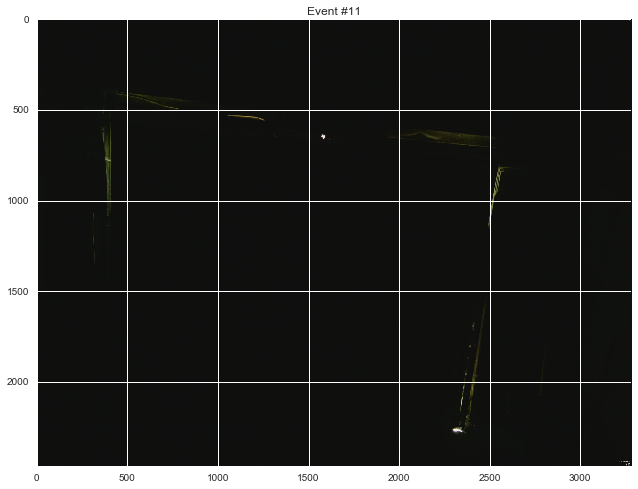

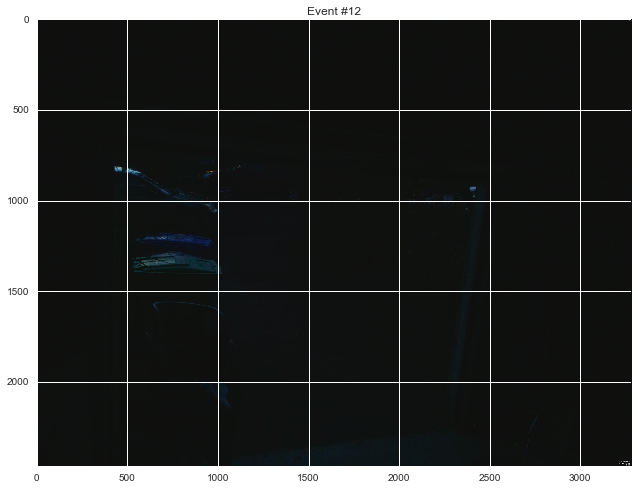

In [3]:
open_filenames = []
event_number = None
for time_step, is_open_now, filename, event_num in zip(file_times, is_open, filenames, event_numbers):
    if is_open_now:
        open_filenames.append(filename)
        event_number = event_num
    else:
        if len(open_filenames) > 0:
            selected_filename = open_filenames[len(open_filenames)/2]
            image = Image.open(selected_filename)
            plt.figure(figsize=(15,8))
            plt.title('Event #'+str(event_number))
            plt.imshow(np.asarray(image))
            plt.show()
        open_filenames = []


In [7]:
df = pd.DataFrame(np.transpose([event_numbers, filenames, file_sizes, is_open]),
                  columns = ['event_number', 'filename', 'file_size', 'is_open']
                 ).convert_objects(convert_numeric=True)
df.loc[ df.event_number == 5, 'is_open' ] = 0
df.loc[ df.event_number == 8, 'is_open' ] = 0
df.loc[ df.event_number == 9, 'is_open' ] = 0
df.loc[ df.event_number == 10, 'is_open' ] = 0
df.loc[ df.event_number == 11, 'is_open' ] = 0

df.to_csv('is_open.csv')

/Users/home/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


# ML Detection 

In [2]:
df = pd.read_csv('is_open.csv')
df.groupby('is_open').count()

Unnamed: 0  event_number  filename  file_size
is_open                                               
0               743           743       743        743
1               264           264       264        264

In [3]:
from PIL import Image, ImageOps

df['prepared_filename'] = map(lambda filename: filename.replace('images/', 'prepared_images/'), df.filename)
df.head()

Unnamed: 0  event_number                         filename  file_size  \
0           0             1  images/01-20170930072332-00.jpg     161410   
1           1             1  images/01-20170930072333-00.jpg     176703   
2           2             1  images/01-20170930072334-00.jpg     186909   
3           3             1  images/01-20170930072335-00.jpg     196170   
4           4             1  images/01-20170930072336-00.jpg     218983   

   is_open                         prepared_filename  
0        1  prepared_images/01-20170930072332-00.jpg  
1        1  prepared_images/01-20170930072333-00.jpg  
2        1  prepared_images/01-20170930072334-00.jpg  
3        1  prepared_images/01-20170930072335-00.jpg  
4        1  prepared_images/01-20170930072336-00.jpg

In [4]:
# Prepare smaller grey-scale images
for filename, prepared_filename in zip(df.filename, df.prepared_filename):
    if os.path.isfile(prepared_filename):
        continue
    print prepared_filename
    
    image = Image.open(filename)
    image = ImageOps.fit(image, (328, 246), Image.ANTIALIAS)
    image = image.convert('L')
    image.save(prepared_filename)

In [5]:
# images = [np.reshape(np.asarray(Image.open(filename)), (-1)) for filename in df.filename]

In [6]:
sample_size = 500
samples = pd.concat([df[ df.is_open == 0].sample(n=sample_size/2), df[ df.is_open == 1].sample(n=sample_size/2)])
print samples.shape
samples.sample(n=5)

(500, 6)


Unnamed: 0  event_number                               filename  \
533         533             7        images/08-20170930125947-00.jpg   
480         480             7  images/06-20170930123400-snapshot.jpg   
53           53             0  images/01-20170930082600-snapshot.jpg   
301         301             4        images/03-20170930104110-00.jpg   
239         239             3        images/02-20170930103439-00.jpg   

     file_size  is_open                               prepared_filename  
533     665449        1        prepared_images/08-20170930125947-00.jpg  
480     320431        1  prepared_images/06-20170930123400-snapshot.jpg  
53      131236        0  prepared_images/01-20170930082600-snapshot.jpg  
301     717209        1        prepared_images/03-20170930104110-00.jpg  
239     725180        1        prepared_images/02-20170930103439-00.jpg

In [7]:
t1 = time.time()
images = [np.reshape(np.asarray(Image.open(filename)), (-1)) for filename in samples.prepared_filename]
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

0.669359922409 ( 0.00133871984482 )


1.83606100082 ( 0.00367212200165 )


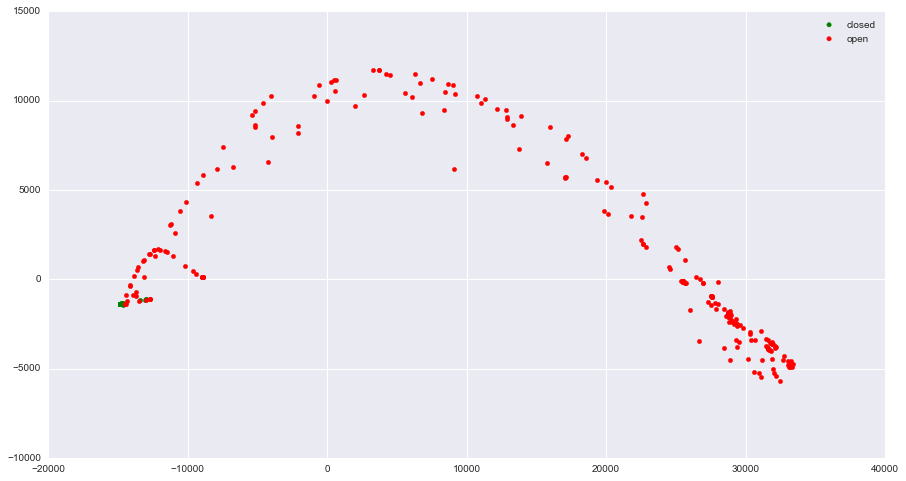

In [8]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=2)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

plt.figure(figsize=(15,8))
vectors_closed = vectors[ (samples.is_open == 0).values ]
vectors_open = vectors[ (samples.is_open == 1).values ]
plt.scatter(x=vectors_closed[0], y=vectors_closed[1], color='green', label='closed')
plt.scatter(x=vectors_open[0], y=vectors_open[1], color='red', label='open')
plt.legend()
plt.show()

1.89085292816 ( 0.00378170585632 )


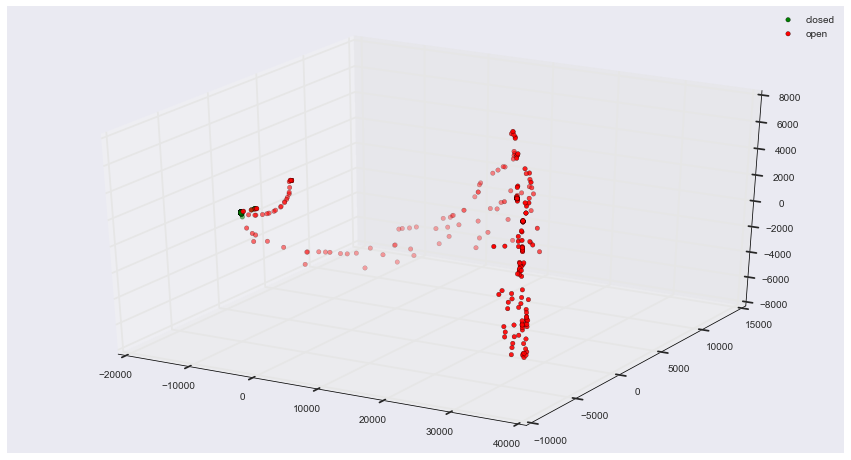

In [9]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=3)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
vectors_closed = vectors[ (samples.is_open == 0).values ]
vectors_open = vectors[ (samples.is_open == 1).values ]
ax.scatter(vectors_closed[0], vectors_closed[1], vectors_closed[2], c='green', label='closed')
ax.scatter(vectors_open[0], vectors_open[1],  vectors_open[2], c='red', label='open')
ax.legend()
plt.show()

1.72730779648 ( 0.00345461559296 )


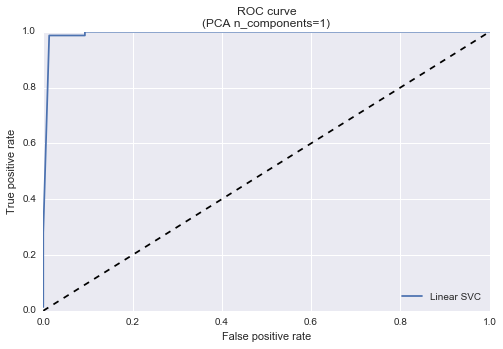

1.74952793121 ( 0.00349905586243 )


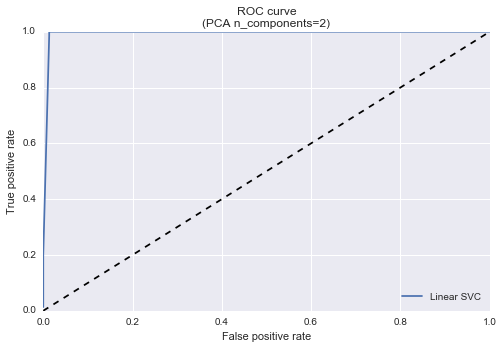

1.85988712311 ( 0.00371977424622 )


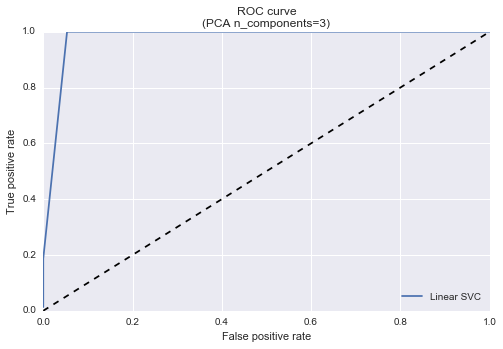

In [10]:
for n_components in [1,2,3]:
    from sklearn.decomposition import PCA
    t1 = time.time()
    pca = PCA(n_components=n_components)
    pca.fit(images)
    vectors = pd.DataFrame(pca.transform(images))
    t2 = time.time()
    print (t2-t1),'(',(t2-t1)/sample_size,')'

    from sklearn.model_selection import train_test_split

    X = vectors
    y = samples.is_open
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7, stratify=y, random_state=123)

    from sklearn.metrics import roc_curve

    from sklearn import svm
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)  
    y_pred_rt = clf.predict_proba(X_test)[:, 1]
    fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

    plt.figure(1, figsize=(8,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label='Linear SVC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve\n(PCA n_components='+str(n_components)+')')
    plt.legend(loc='best')
    plt.show()



1.79354190826 ( 0.00358708381653 )
[[57 18]
 [ 0 75]]


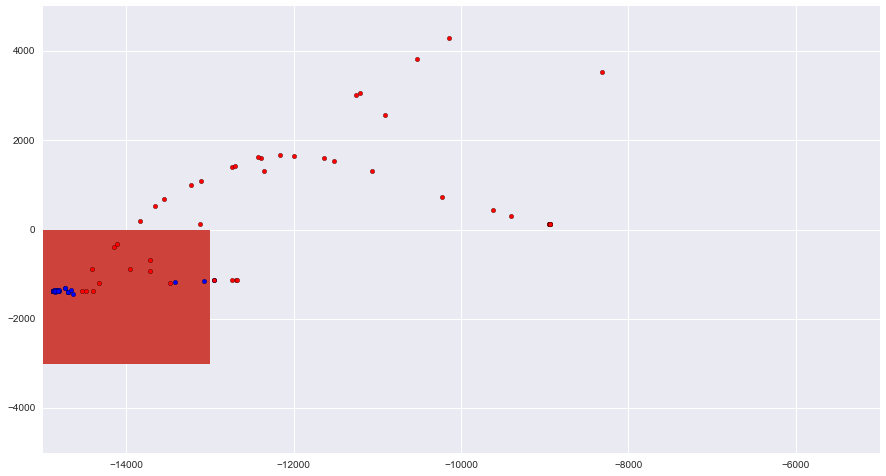

In [20]:
classes = ['open', 'closed']
plot_colors = "br"
plot_steps = 200

from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=2)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images)).values
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

from sklearn.model_selection import train_test_split

X = vectors
y = samples.is_open
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7, stratify=y, random_state=123)

from sklearn import svm
clf = svm.SVC(probability=False)
# clf = svm.SVC(kernel='rbf', gamma=0.7)
# clf = svm.SVC(kernel='poly', degree=3)
# clf = svm.LinearSVC()
clf.fit(X_train, y_train)  

from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
print confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,8))
from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier().fit(X_test, y_test)
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x_min, x_max = [-15000, -13000]
y_min, y_max = [-3000, 0]
plt.xlim(-15000, -5000)
plt.ylim(-5000, 5000)
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/plot_steps), np.arange(y_min, y_max, (y_max-y_min)/plot_steps))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)

for i, color in zip(range(len(classes)), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=classes[i],
                cmap=plt.cm.coolwarm)